In [3]:
from pathlib import Path

import polars as pl

from plot_functions import distribution_plot, line_plot_variables
from utils.metrics_process import read_metrics, get_assistant_data, aggregate_df

## SETUP

In [4]:
# prompt version (currently only working with 2.0, but nice to be able to easily change)
version = 3.0

In [5]:
metrics_dir = Path.cwd().parents[0] / "metrics"

plots_dir = Path.cwd().parents[0] / "plots" / f"v{version}"

results_dir = Path.cwd().parents[0] / "results" / f"v{version}"

curves_dir = plots_dir / "curves"
dist_dir = plots_dir / "dists"

for dir in [curves_dir, dist_dir, results_dir]:
    dir.mkdir(parents=True, exist_ok=True)

In [6]:
# for giving shorter names in df 
model_dict = {
    "meta-llama--Llama-3.1-8B-Instruct": "Llama 3.1 8B Instruct",
    "google--gemma-3-12b-it": "Gemma 3 12B IT",
    "mistralai--Mistral-7B-Instruct-v0.3": "Mistral 7B Instruct v0.3",
    "Qwen--Qwen2.5-7B-Instruct": "Qwen 2.5 7B Instruct",
}

unique_models = model_dict.values()

pad_inches = 0.1

## TEXT STATS: Load and Process

In [7]:
df = read_metrics(metrics_path=metrics_dir, model_dict=model_dict, version=version, metric_types=["text_stats"])
assistant_df = get_assistant_data(df)

In [8]:
cols = ["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini", "flesch_kincaid_grade", "crawford"]

# aggregate data
agg_df = aggregate_df(assistant_df, cols_to_aggregate=cols, ci_to_cols=True)

### Plot

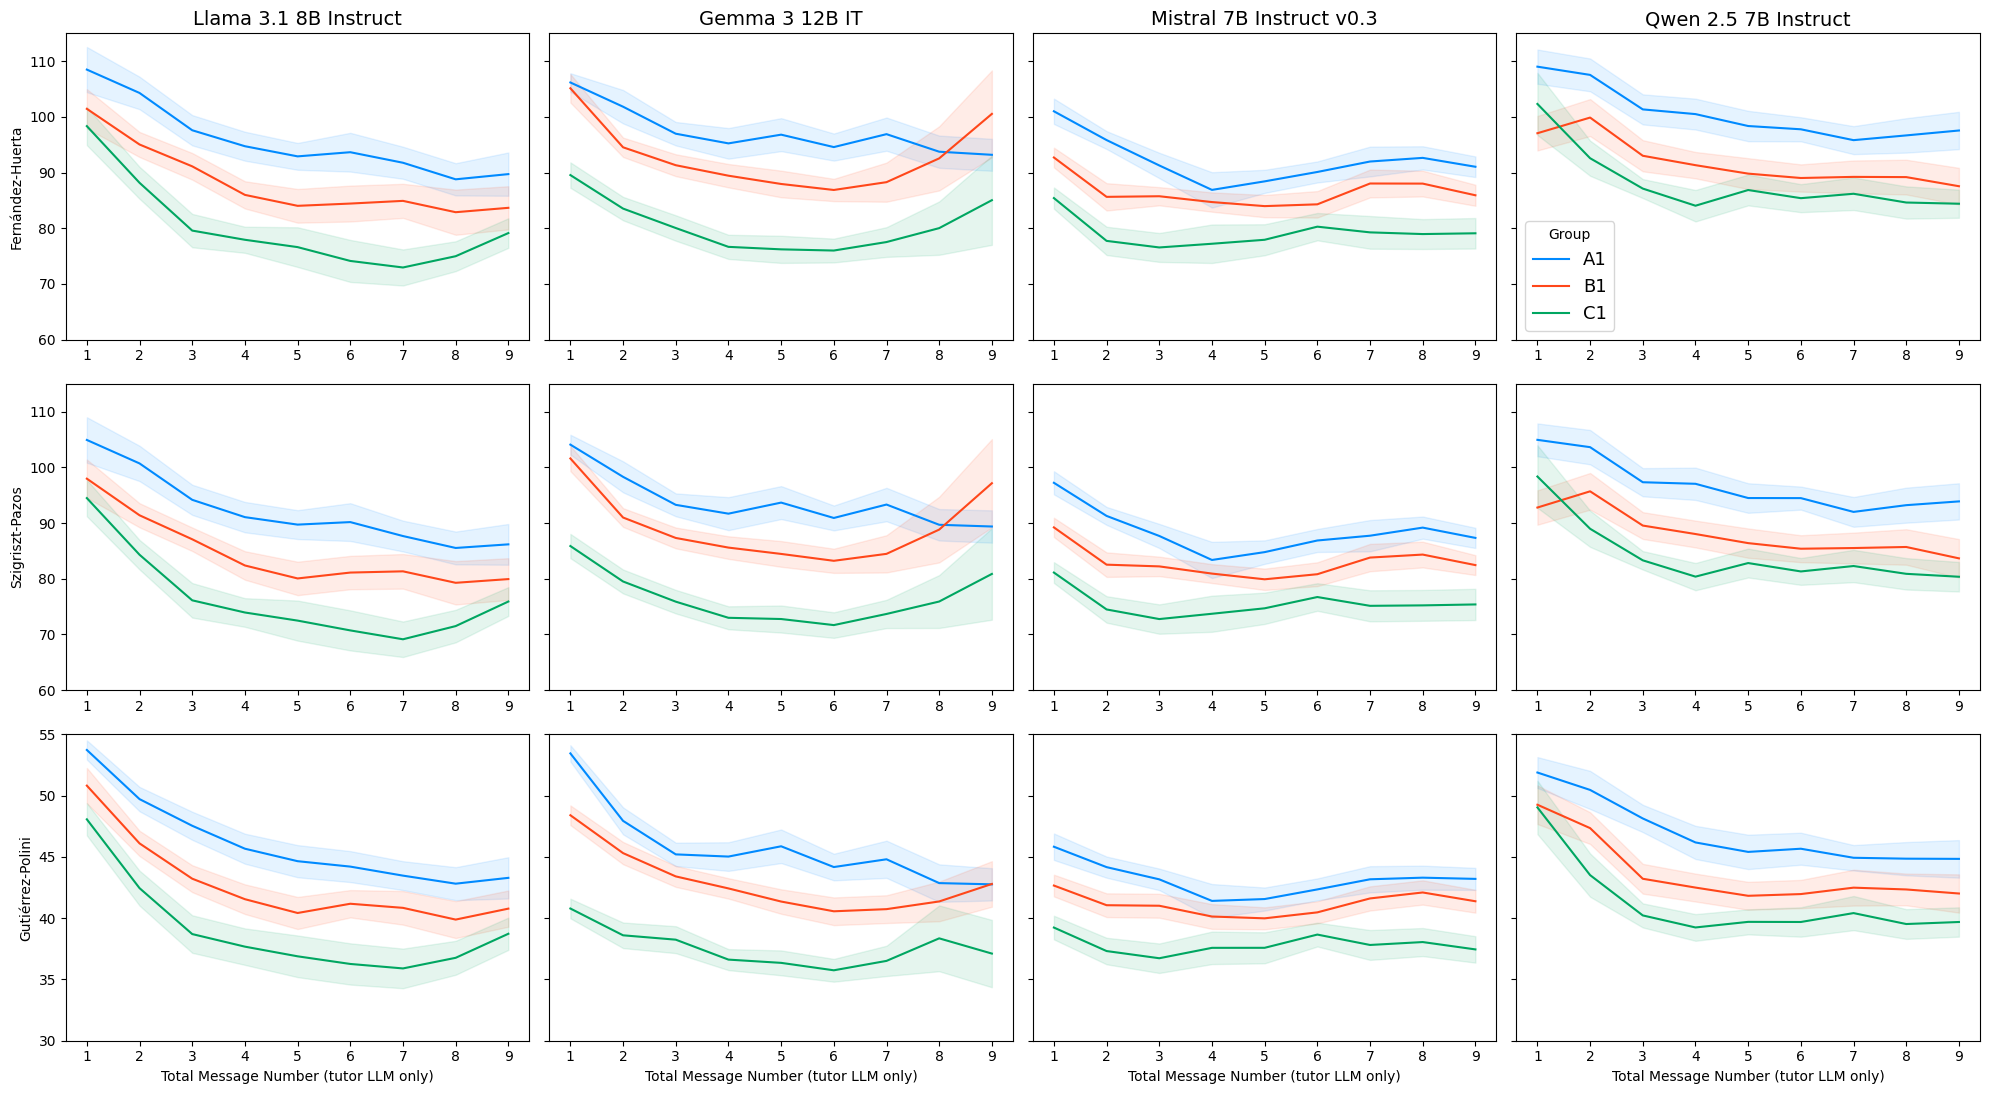

In [9]:
colors = ["#008aff", "#ff471a", "#00a661"]

cols = ["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini"]
vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars, 
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model",
                    unique_models=unique_models,
                    x_label_text="Total Message Number (tutor LLM only)", 
                    y_label_texts=["Fernández-Huerta", "Szigriszt-Pazos", "Gutiérrez-Polini"],
                    y_lims={"fernandez_huerta_mean": (60, 115), "szigriszt_pazos_mean": (60, 115), "gutierrez_polini_mean": (30, 55)},
                    group_colors=colors)

fig.savefig(curves_dir / "spanish_readability_high_easy_curves.png", dpi=300, bbox_inches="tight", pad_inches=pad_inches)

In [10]:
# round before saving
decimals = 2

save_agg_df = agg_df.with_columns(
        fernandez_huerta_mean = pl.col("fernandez_huerta_mean").round(decimals),
        szigriszt_pazos_mean = pl.col("szigriszt_pazos_mean").round(decimals),
        gutierrez_polini_mean = pl.col("gutierrez_polini_mean").round(decimals),
        fernandez_huerta_std = pl.col("fernandez_huerta_std").round(decimals),
        szigriszt_pazos_std = pl.col("szigriszt_pazos_std").round(decimals),
        gutierrez_polini_std = pl.col("gutierrez_polini_std").round(decimals),
)

# only keep these columns
save_agg_df = save_agg_df.select(
        ["model", "group", "total_message_number"] + vars
)

save_agg_df.write_csv(results_dir / "agg_spanish_readability_high_easy.csv")

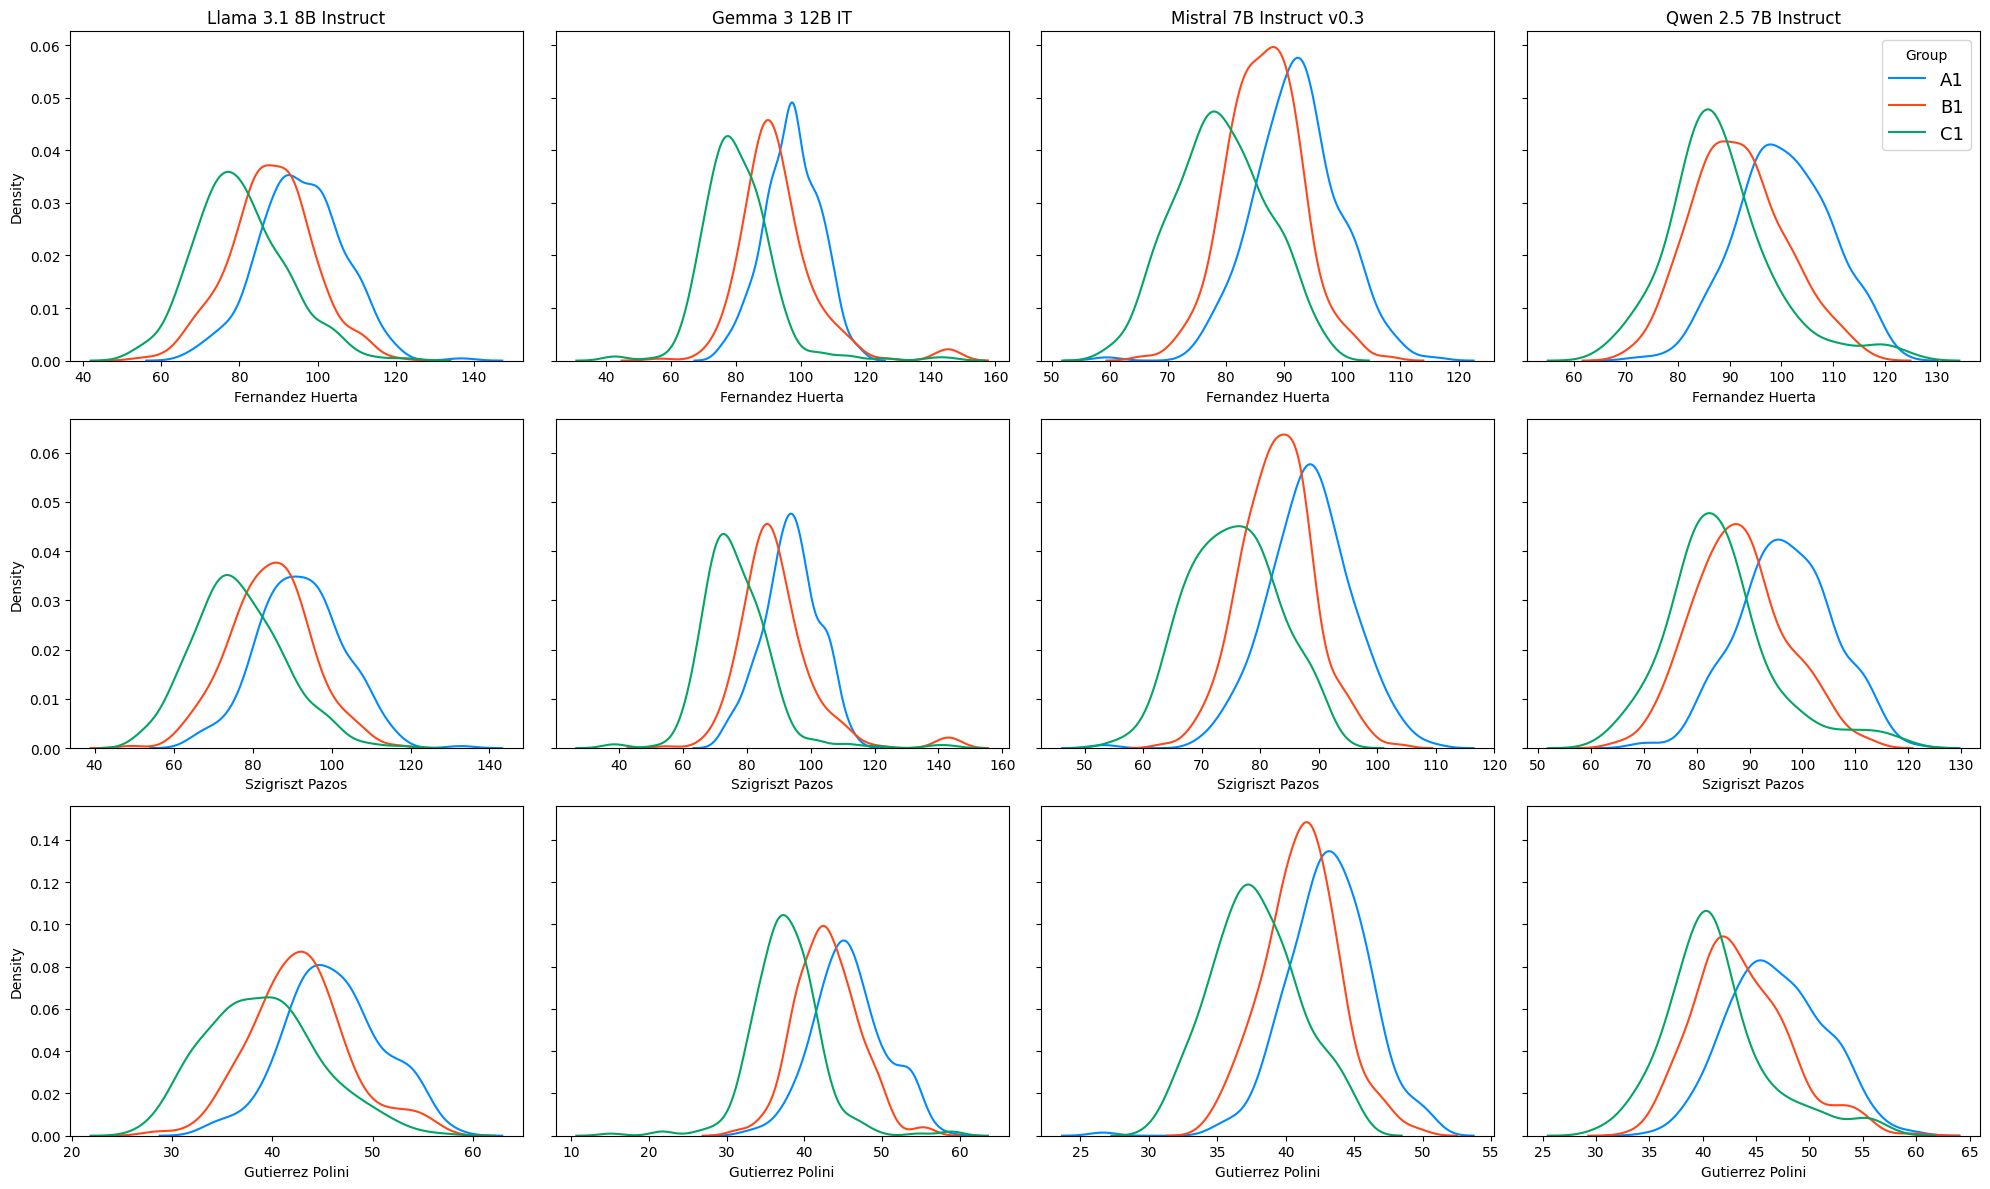

In [11]:
fig = distribution_plot(assistant_df, 
                        x_vars=["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini"], 
                        group_var="group",
                        model_var="model",
                        unique_models=unique_models,
                        normalize=True,
                        x_label_texts=["Fernandez Huerta", "Szigriszt Pazos", "Gutierrez Polini"], 
                        density_lines=True)

fig.savefig(dist_dir / "spanish_readability_high_easy_dist.png", dpi=300, bbox_inches="tight", pad_inches=pad_inches)

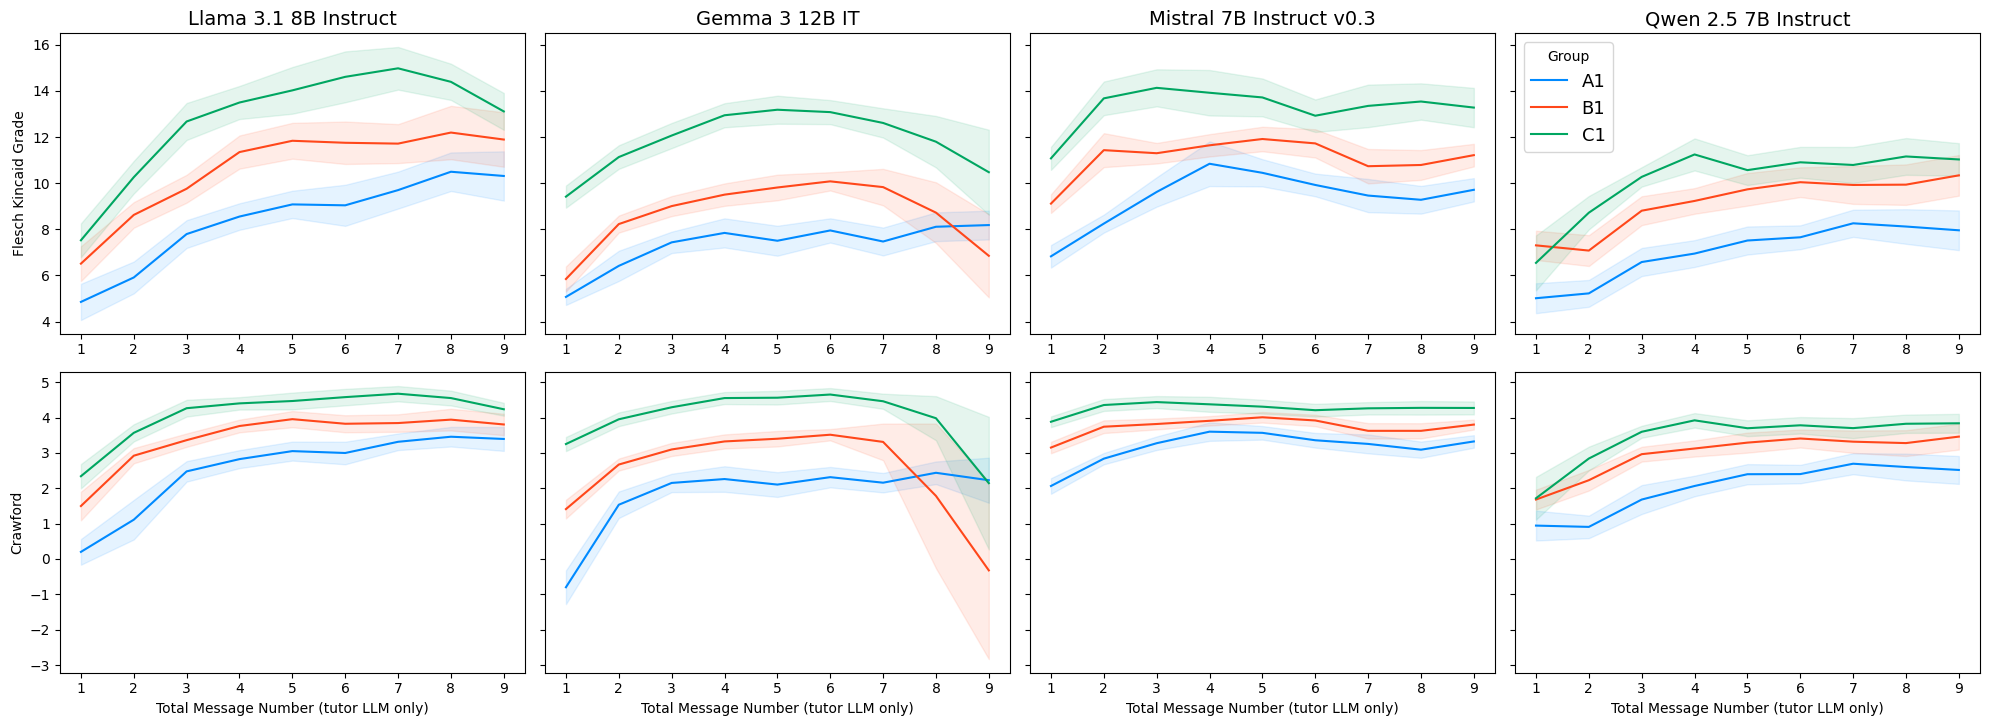

In [12]:
colors = ["#008aff", "#ff471a", "#00a661"]

cols = ["flesch_kincaid_grade", "crawford"]
vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars,
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model", 
                    unique_models=unique_models,
                    x_label_text="Total Message Number (tutor LLM only)", 
                    y_label_texts=["Flesch Kincaid Grade", "Crawford"],
                    group_colors=colors)

fig.savefig(curves_dir / "spanish_readability_high_difficult_curves.png", dpi=300, bbox_inches="tight", pad_inches=pad_inches)

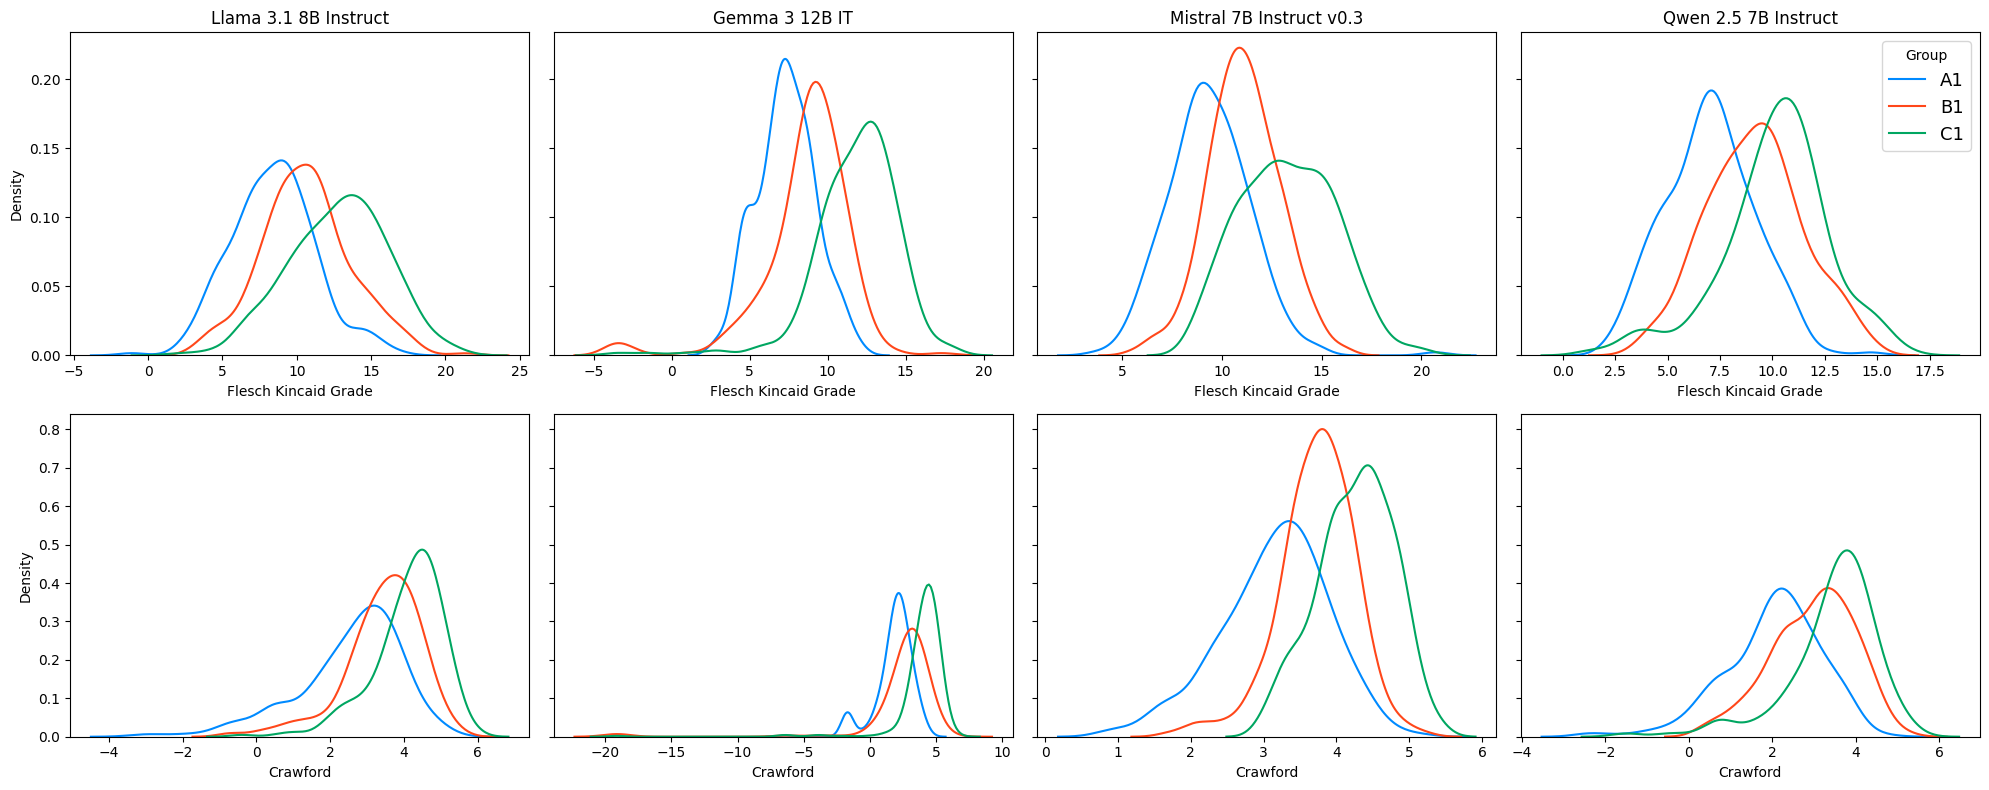

In [13]:
# high difficult dists
fig = distribution_plot(assistant_df, 
                        x_vars=["flesch_kincaid_grade", "crawford"], 
                        group_var="group",
                        model_var="model",
                        unique_models=unique_models,
                        normalize=True,
                        x_label_texts=["Flesch Kincaid Grade", "Crawford"], 
                        density_lines=True)

fig.savefig(dist_dir / "spanish_readability_high_difficult_dist.png", dpi=300, bbox_inches="tight", pad_inches=pad_inches)

## Dependency Distance, Doc Length

In [14]:
df = read_metrics(metrics_path=metrics_dir, model_dict=model_dict, version=version, metric_types=["textdescriptives"])
assistant_df = get_assistant_data(df)

In [15]:
cols = ["doc_length", "dependency_distance_mean"]
agg_df = aggregate_df(assistant_df, cols_to_aggregate=cols, ci_to_cols=True)

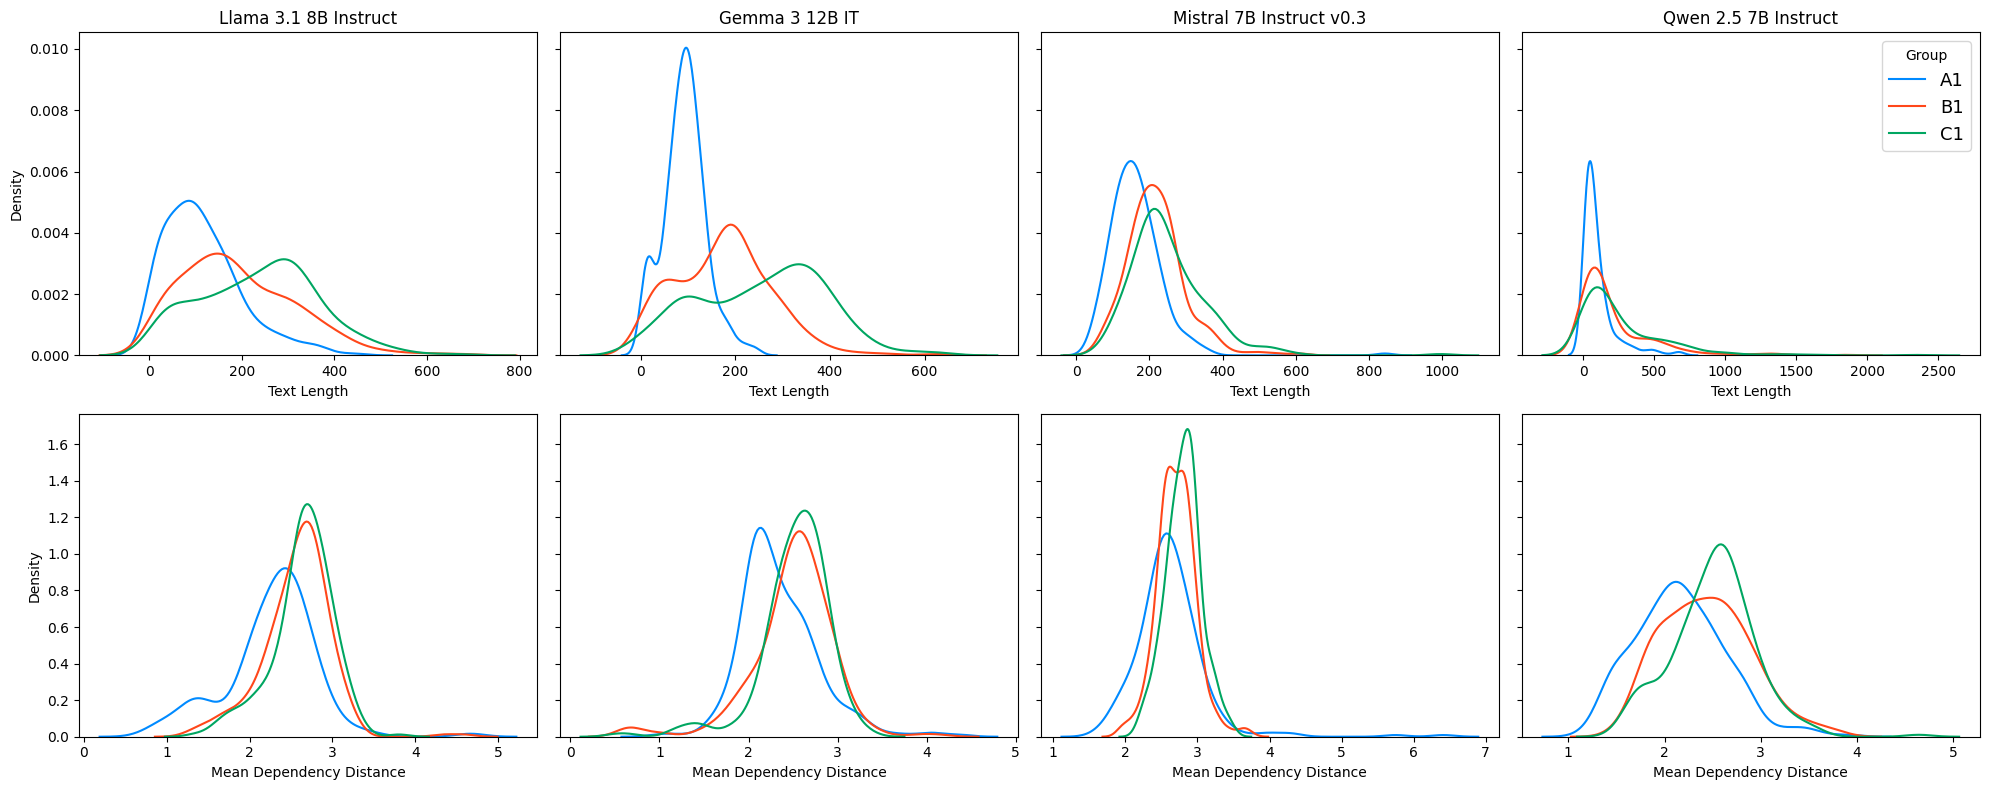

In [16]:
fig = distribution_plot(assistant_df, 
                        x_vars=["doc_length", "dependency_distance_mean"], 
                        group_var="group",
                        model_var="model",
                        unique_models=unique_models,
                        normalize=True,
                        x_label_texts=["Text Length", "Mean Dependency Distance"], 
                        density_lines=True)

fig.savefig(dist_dir / "doc_length_and_MDD_dist.png", dpi=300, bbox_inches="tight", pad_inches=pad_inches)

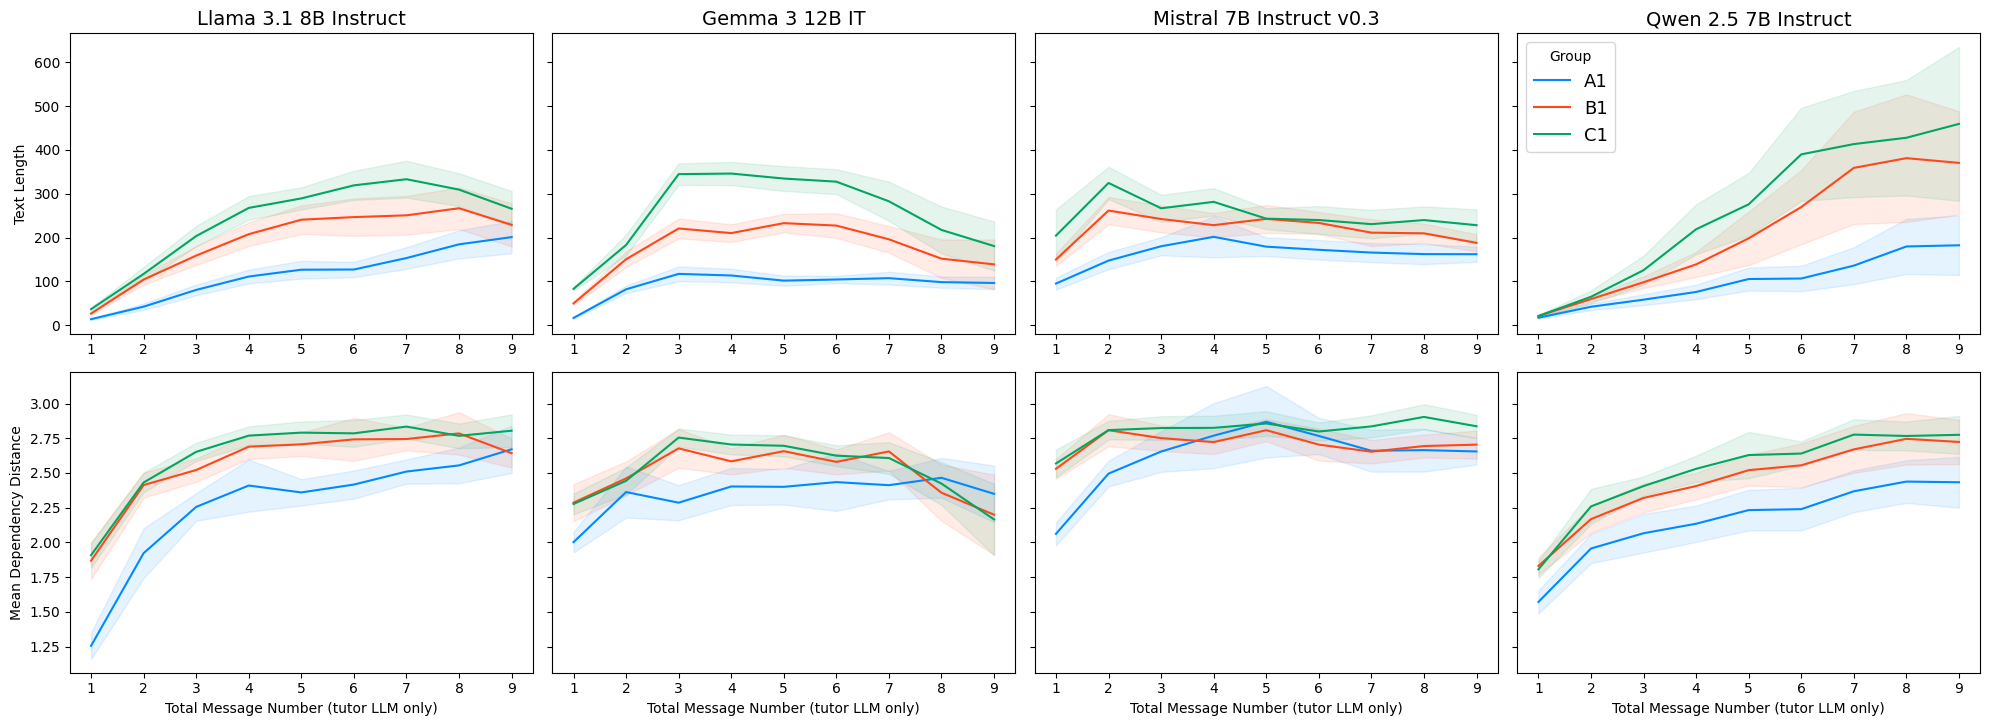

In [17]:
cols = ["doc_length", "dependency_distance_mean"] # consider number of sentences
vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]


fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars,
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model", 
                    unique_models=unique_models,
                    x_label_text="Total Message Number (tutor LLM only)", 
                    y_label_texts=["Text Length", "Mean Dependency Distance"],
                    group_colors=colors)

fig.savefig(curves_dir / "doc_length_and_MDD_curve.png", dpi=300, bbox_inches="tight", pad_inches=pad_inches)

[INFO:] No unique models provided. Using all models in the dataframe.


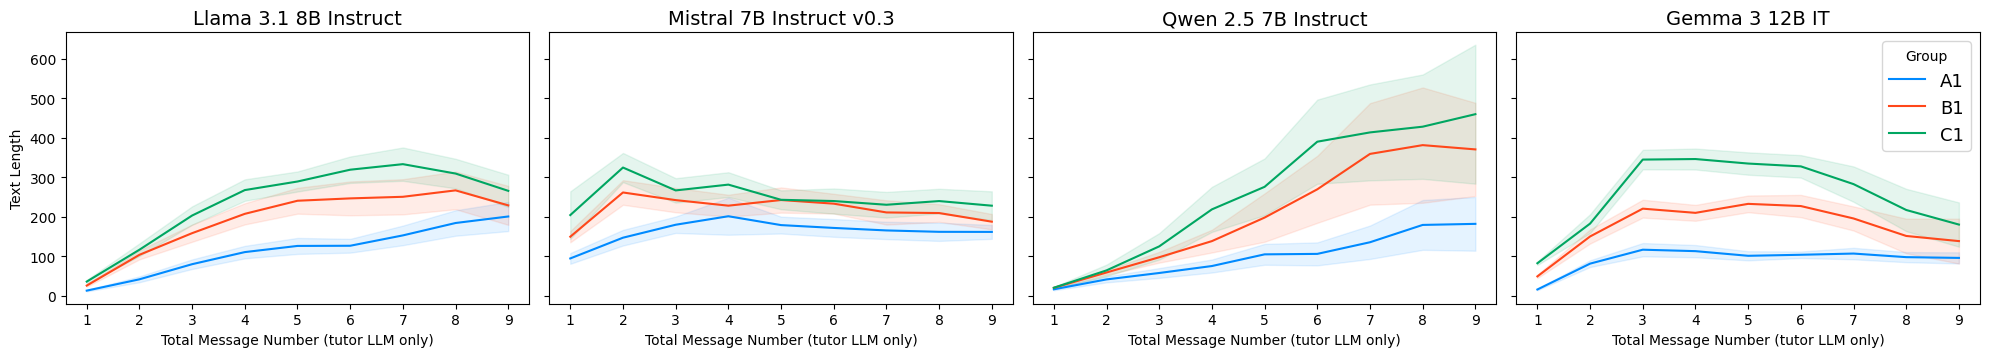

In [18]:
cols = ["doc_length"] # consider number of sentences
vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]


fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars,
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    y_label_texts=["Text Length"],
                    group_colors=colors)

## Surprisals

In [19]:
df = read_metrics(metrics_path=metrics_dir, model_dict=model_dict, version=version, metric_types=["surprisal"])
assistant_df = get_assistant_data(df)

# rename to paragraph
assistant_df = assistant_df.with_columns(
    pl.col("surprisal_mean").alias("surprisal_paragraph")
)

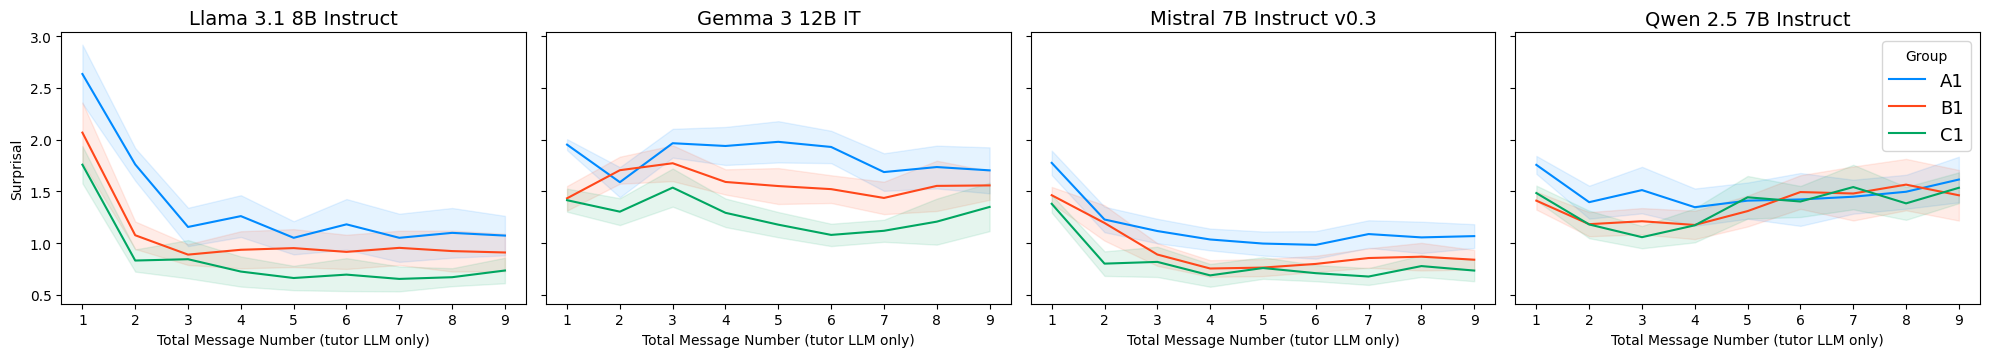

In [20]:
cols = ["surprisal_paragraph"]

# aggregate data
agg_df = aggregate_df(assistant_df, cols_to_aggregate=cols, ci_to_cols=True)

colors = ["#008aff", "#ff471a", "#00a661"]

vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars, 
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model", 
                    unique_models=unique_models,
                    x_label_text="Total Message Number (tutor LLM only)", 
                    y_label_texts=["Surprisal"],
                    group_colors=colors)

fig.savefig(curves_dir / "surprisal_curve.png", dpi=300, bbox_inches="tight", pad_inches=pad_inches)

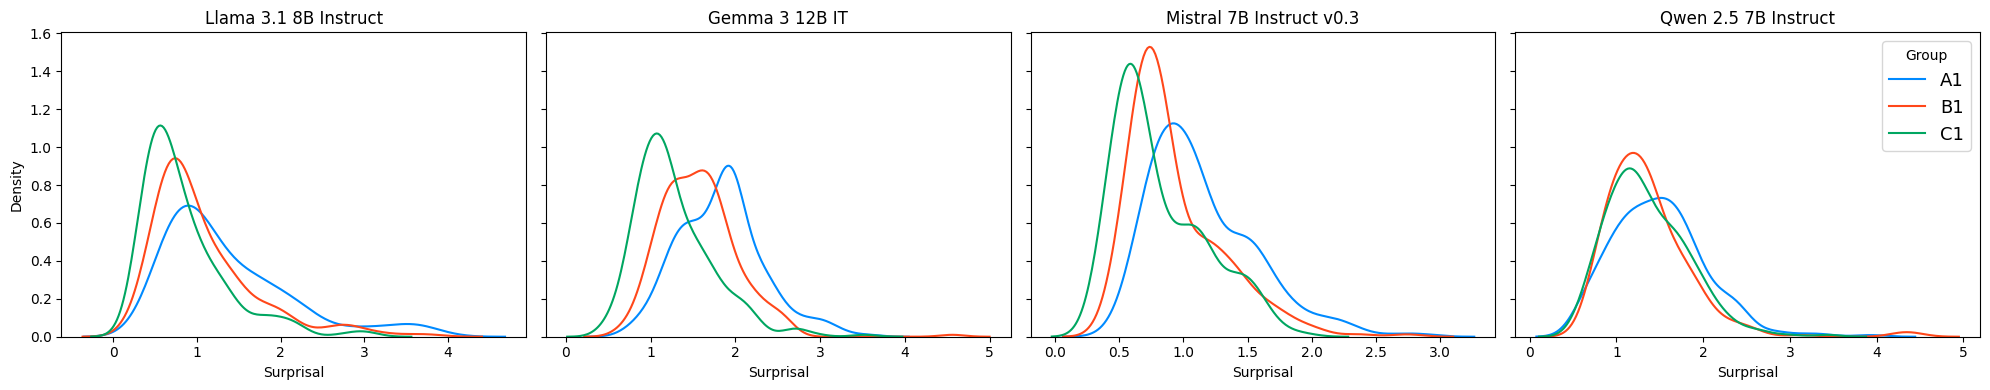

In [21]:
# distribution plot
fig = distribution_plot(assistant_df, 
                        x_vars=["surprisal_paragraph"], 
                        normalize=True,
                        alpha=0.5, 
                        group_var="group",
                        model_var="model",
                        unique_models=unique_models,
                        x_label_texts=["Surprisal"], 
                        density_lines=True)

fig.savefig(dist_dir / "surprisal_dist.png", dpi=300, bbox_inches="tight", pad_inches=pad_inches)